In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer


%matplotlib inline

In [ ]:
# Functions
def classify_columns(df, target, verbose= False):

    features = df.columns[(df.columns != target)].tolist()
    categorical = df.dtypes[(df.dtypes == "object") & (df.columns != target)].index.tolist()
    numerical = [col for col in features if col not in categorical and col != target]

    if verbose:
        print("Total number of features:", len(features))
        print("Numerical:", len(numerical))
        print("Categorical:", len(categorical))

    return features, categorical, numerical

def build_preprocessor(categorical_cols, numerical_cols):
    # Preprocessing for categorical data
    categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    # Preprocessing for numerical data -> Possible way to improve perfomance
    #numerical_transformer = StandardScaler()

    # Bundle preprocessing for categorical data
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_cols),
            #('num', numerical_transformer, numerical_cols)
        ], remainder='passthrough')

    return preprocessor

def fit_preprocessor(preprocessor, X_train):
    # Fit preprocessor
    X_train_encoded = preprocessor.fit_transform(X_train)
    return X_train_encoded

def transform_dataset(preprocessor, X):
    return preprocessor.transform(X)

def encoded_dataframe(preprocessor, X, index=None):
    X_enc = preprocessor.transform(X)
    cols = preprocessor.get_feature_names_out()
    return pd.DataFrame(X_enc, columns=cols, index=index)

def rebuild_dataframe(preprocessor, X_enc, index=None):
    cols = preprocessor.get_feature_names_out()
    return pd.DataFrame(X_enc, columns=cols, index=index)

def split_features_target(df, target_col):
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    return X, y

def preprocess_dataset(df, categorical_cols, numerical_cols):

      # Fill features
    for feature in numerical_cols:
        df[feature] = df[feature].fillna(0)

    for features in categorical_cols:
        df[feature] = df[feature].fillna("NA")  

    return df

def split_dataset(dataset, test_size = 0.2, val_size = 0.25, seed = 1):
    train_full_df, test_df = train_test_split(dataset, test_size=test_size, random_state=seed)

    train_df, val_df = train_test_split(train_full_df, test_size=val_size, random_state=seed)

    train_df = train_df.reset_index()
    val_df = val_df.reset_index()
    test_df = test_df.reset_index()

    return train_df, val_df, test_df

def train_logistic_regression(X, y, C = 1.0, max_iter = 1000):
    model = LogisticRegression(solver="liblinear", C = C, max_iter = max_iter)

    model.fit(X, y)

    return model

def predict_y(model, X, pred_type="prob", threshold=0.5, verbose=False):
    y_proba = model.predict_proba(X)[:, 1]

    if pred_type == "prob":
        if verbose:
            print("Returning probabilities")
        return y_proba
    else:
        if verbose:
            print("Returning classes")
        return (y_proba >= threshold).astype(int)
    
def use_metric(y, y_pred, eval_method):
    if eval_method == "accuracy":
        return (y == y_pred).mean()
    elif eval_method == "precision":
        return precision_score(y, y_pred, zero_division=1)
    elif eval_method == "recall":
        return recall_score(y, y_pred)
    elif eval_method == "f1":
        return f1_score(y, y_pred)
    elif eval_method == "roc_auc":
        return roc_auc_score(y, y_pred)
    else:
        raise ValueError("Unknown eval method")

def kfold_cross_validation(X, y, C=1, num_folds=5, is_shuffled = True, seed = 1, verbose = False):
    # Initialize KFold
    kfold = KFold(n_splits=num_folds, shuffle=is_shuffled, random_state=seed)

    scores = []

    # Iterate over folds
    for train_idx, val_idx in kfold.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Train logistic regression
        model = train_logistic_regression(X_train, y_train, C = C)

        # Predict probabilities for AUC
        y_pred = predict_y(model, X_val, "prob")

        # Evaluate
        auc = use_metric(y_val, y_pred, "roc_auc")
        scores.append(auc)

    # Compute mean and std of AUCs
    mean_auc = np.mean(scores)
    std_auc = np.std(scores)

    if verbose:
        print(f"AUCs across folds: {scores}")
        print(f"Mean AUC: {mean_auc:.3f}")
        print(f"Std of AUC: {std_auc:.3f}")

    return mean_auc, std_auc

In [ ]:
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"
target_col = "converted"

In [4]:
df = pd.read_csv(url)

In [5]:
print("Number of empty entries", df.isnull().sum().sum())

Number of empty entries 606


In [6]:
# Column distinction
features_cols, categorical_cols, numerical_cols = classify_columns(df, target_col)

<Axes: xlabel='converted', ylabel='percent'>

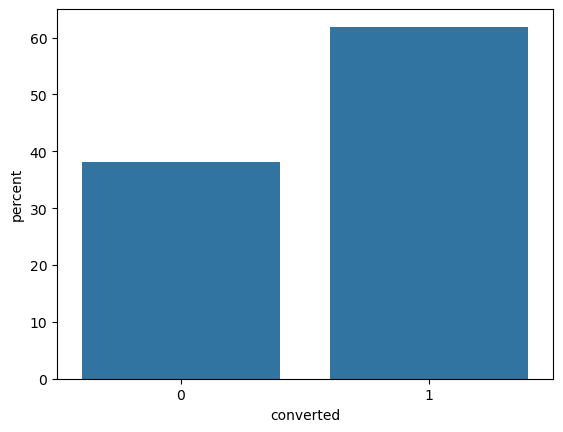

In [7]:
# EDA check y variable 
fig, ax = plt.subplots()
sns.countplot(data=df, x=target_col, ax= ax, stat="percent")


In [8]:
# split dataset
df = preprocess_dataset(df, categorical_cols, numerical_cols)
train_df, val_df, test_df = split_dataset(df)

In [9]:
# Q1: ROC AUC feature importance

features = ["lead_score", "number_of_courses_viewed", "interaction_count", "annual_income"]

auc_scores = {}
for f in features:
    print(f"Feature: {f}")
    auc = use_metric(train_df[target_col], train_df[f], "roc_auc")
    print(f"ROC AUC: {auc}\n")

    if auc < 0.5:
        train_df[f] = - train_df[f]

    auc_scores[f] = auc
    

Feature: lead_score
ROC AUC: 0.6144993577250176

Feature: number_of_courses_viewed
ROC AUC: 0.7635680590007088

Feature: interaction_count
ROC AUC: 0.738270176293409

Feature: annual_income
ROC AUC: 0.5519578313253012



In [10]:
# Q2: Training the model 

processor = build_preprocessor(categorical_cols, numerical_cols)

X_train, y_train = split_features_target(train_df, target_col)
X_train_en = fit_preprocessor(processor, X_train)

In [11]:
# Train the model
model = train_logistic_regression(X_train_en, y_train)

# Evaluate on validation set
X_val, y_val = split_features_target(val_df, target_col)
X_val_en = transform_dataset(processor, X_val)

y_pred_prob = predict_y(model, X_val_en, pred_type="prob")
val_auc = use_metric(y_val, y_pred_prob, eval_method="roc_auc")
print("Validation ROC AUC:", val_auc)

Validation ROC AUC: 0.827149841817659


In [12]:
# Q3: Precision & Recall

threshold_values = np.arange(0.0, 1.0, 0.01)
eval_scores = {}
for t in threshold_values:
    y_pred = predict_y(model, X_val_en, pred_type="class", threshold=t)
    p_score = use_metric(y_val, y_pred, "precision")
    r_score = use_metric(y_val, y_pred, "recall")
    f_score = use_metric(y_val, y_pred, "f1") # Added for Q4
    eval_scores[t] = [p_score, r_score, f_score]

df_scores = pd.DataFrame.from_dict(eval_scores, orient='index', columns=['precision', 'recall', "f1_score"])
df_scores["diff"] = np.abs(df_scores["precision"] - df_scores["recall"])


Text(0.5, 1.0, 'Precision and Recall vs. Threshold')

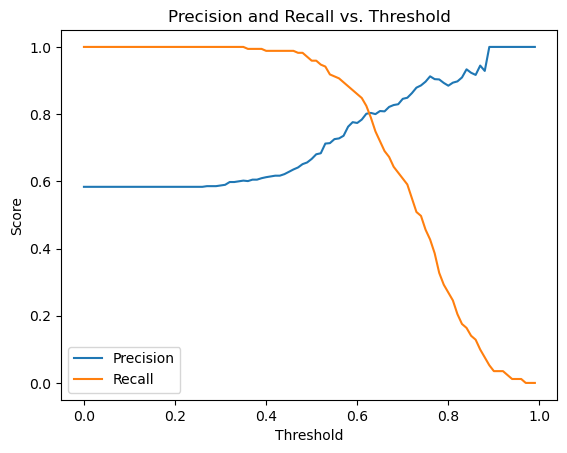

In [13]:

# Plot
sns.lineplot(data=df_scores, x=df_scores.index, y="precision", label='Precision')
sns.lineplot(data=df_scores, x=df_scores.index, y="recall", label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')

In [14]:
print("Threshold with minimum difference between Precision and Recall:", df_scores["diff"].idxmin())

Threshold with minimum difference between Precision and Recall: 0.63


The maximum value of f1 score 0.821
Corresponding threshold value 0.59


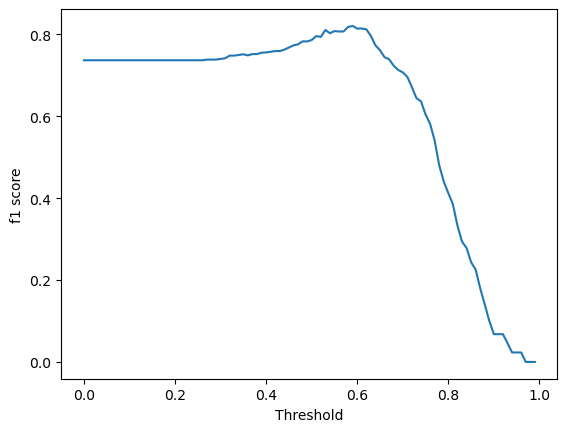

In [15]:
# Q4: F1 Score 

sns.lineplot(data=df_scores, x= df_scores.index, y="f1_score")
plt.xlabel("Threshold")
plt.ylabel("f1 score")
print(f"The maximum value of f1 score {df_scores["f1_score"].max():.3f}")
print(f"Corresponding threshold value {df_scores["f1_score"].idxmax()}")

In [16]:
# Q5: 5-fold CV 

# Merge train and val sets
X_full_train_en = np.vstack([X_train_en, X_val_en])
y_full_train = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)


In [17]:
mean, std = kfold_cross_validation(X_full_train_en, y_full_train, verbose=True)

AUCs across folds: [0.8430309007232084, 0.8170768307322929, 0.8292534126439411, 0.8183130699088146, 0.8685961925398545]
Mean AUC: 0.835
Std of AUC: 0.019


In [18]:
#Q6: Hyperparameter tuning

C_list = [0.000001, 0.001, 1]

for c in C_list:
    print(f"\nC: {c}")
    mean, std = kfold_cross_validation(X_full_train_en, y_full_train, C=c, verbose=True)


C: 1e-06
AUCs across folds: [0.5801282051282051, 0.5716536614645858, 0.5192557004499352, 0.6178571428571429, 0.5006964866119795]
Mean AUC: 0.558
Std of AUC: 0.043

C: 0.001
AUCs across folds: [0.8507560815253122, 0.8356092436974789, 0.8262030046518722, 0.8221124620060789, 0.864417272867977]
Mean AUC: 0.840
Std of AUC: 0.016

C: 1
AUCs across folds: [0.8430309007232084, 0.8170768307322929, 0.8292534126439411, 0.8183130699088146, 0.8685961925398545]
Mean AUC: 0.835
Std of AUC: 0.019
